# Plot EDGAR dataset
The dataset is from timestamp **2016-10-01 00:00:00** to **2016-12-31 23:00:00**  
**requests** represents the maximum number of requests received by the webserver within the given hour, with a resolution of 1s

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [12]:
def parse_datetime(x):
    # return pandas datetime
    return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')

series = pd.read_csv(
    './Processed/EDGAR/access.csv', # filename
    header=None, # contains no header
    index_col=0, # set datetime column as index
    names=['datetime', 'requests'], # name the columns
    converters={'datetime': parse_datetime}, # custom datetime parser
    squeeze=True, # convert to Series
    dtype={'requests': np.float64} # https://git.io/vdbyk
)

--- HEAD ---
datetime
2016-10-01 00:00:00     628.0
2016-10-01 01:00:00     644.0
2016-10-01 02:00:00     477.0
2016-10-01 03:00:00     460.0
2016-10-01 04:00:00    5291.0
Name: requests, dtype: float64
--- TAIL ---
datetime
2016-12-31 19:00:00    567.0
2016-12-31 20:00:00    446.0
2016-12-31 21:00:00    556.0
2016-12-31 22:00:00    558.0
2016-12-31 23:00:00    263.0
Name: requests, dtype: float64


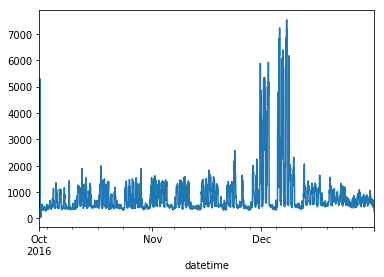

In [13]:
print('--- HEAD ---')
print(series.head())
print('--- TAIL ---')
print(series.tail())

series.plot();

# Naive forecast
The last observed value will occur in the next time interval

In [14]:
print(series[series.last_valid_index()])

263.0


# Autoregressive (AR)
It is a regression of the variable against itself.  
The model is represented as *AR(p)*, where the *AR* process depends on *p* past observations.  

We will be computing *AR(1)*, which is equivalent to *ARIMA(1,0,0)* and *ARMA(1,0)*.

[ 356.52925853  435.17776403  501.31308375  556.92609873  603.69093557
  643.01536286  676.0831695   703.88980042  727.27232262  746.93462354
  763.46860025  777.37197742  789.06329041  798.89448451  807.16150956
  814.113229    819.95891144  824.87453031  829.00806118  832.48393633
  835.40679052  837.86461087  839.93138547  841.66933076  843.13076435
  844.35967997  845.39307186  846.26204837  846.9927684   847.60722894
  848.12392718  848.55841736  848.923779    849.23101063  849.4893609
  849.70660695  849.88928858  850.04290508  850.17208079  850.2807043
  850.37204552  850.44885411  850.51344225  850.56775424  850.61342506
  850.65182952  850.68412374  850.71127986]


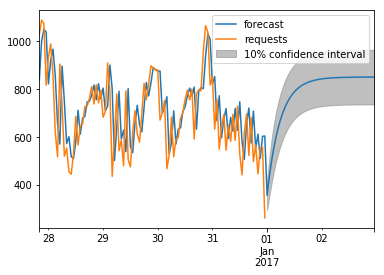

In [15]:
from statsmodels.tsa.arima_model import ARMA

ar = ARMA(series, order=(1,0)) # (p,q) = (1,0)
ar_fit = ar.fit()

print(ar_fit.forecast(48)[0])
ar_fit.plot_predict(start=series.tail(100).index[0],
                    end=series.last_valid_index() + pd.Timedelta(hours=48),
                    alpha=0.90);

# Autoregressive Moving Averages (ARMA)
The model is represented as *ARMA(p,q)*,  
where the *AR* process depends on *p* past observations and *MA* process depends on *q* past observations.  

We will be computing *ARMA(1,1)*, which is equivalent to *ARIMA(1,0,1)*.

[ 393.78092464  436.43630013  475.12555001  510.21744731  542.0464763
  570.91602069  597.10125534  620.85176919  642.39394422  661.93311328
  679.6555172   695.73008004  710.31001917  723.53430571  735.52898916
  746.40839885  756.27623367  765.22655055  773.34466093  780.70794391
  787.38658388  793.44423939  798.93865     803.9221866   808.4423506
  812.54222671  816.26089356  819.63379626  822.69308419  825.46791746
  827.98474485  830.26755594  832.33810971  834.216142    835.91955357
  837.46458079  838.86595033  840.13701958  841.28990396  842.33559237
  843.28405197  844.14432315  844.92460574  845.63233712  846.27426316
  846.85650249  847.38460481  847.86360382]


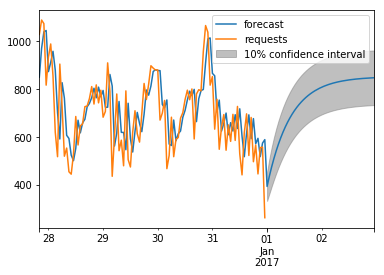

In [16]:
from statsmodels.tsa.arima_model import ARMA

arma = ARMA(series, order=(1,1)) # (p,q) = (1,1)
arma_fit = arma.fit()

print(arma_fit.forecast(48)[0])
arma_fit.plot_predict(start=series.tail(100).index[0],
                      end=series.last_valid_index() + pd.Timedelta(hours=48),
                      alpha=0.90);

# Autoregressive Integrated Moving Averages (ARIMA)
The model is represented as *ARIMA(p,d,q)*,  
where the *AR* process depends on *p* past observations, *MA* process depends on *q* past observations,  
and *d* represents the order of integration (to make time-series stationary).  

We will be computing R's equivalent of *auto.ARIMA()*.

### Check for stationarity
- **p-value** should be < 0.05
- **Test Statistic** should be < **Critical Value (5%)**

[Read More](https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c)

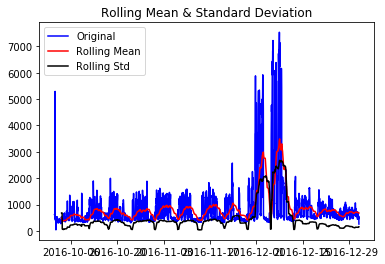

Test Statistic                   -4.450630
p-value                           0.000241
#Lags Used                       27.000000
Number of Observations Used    2180.000000
Critical Value (10%)             -2.567476
Critical Value (5%)              -2.862867
Critical Value (1%)              -3.433353
dtype: float64


In [17]:
from statsmodels.tsa.stattools import adfuller

# Rolling statistics
rolmean = series.rolling(window=52, center=False).mean()
rolstd = series.rolling(window=52, center=False).std()

orig = plt.plot(series, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Dickey-Fuller test
dftest = adfuller(series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

[ 400.42808099  414.36089712  450.32642199  477.76500388  508.55825054
  542.5455479   581.13788389  624.04351152  670.27249684  718.13331444
  765.52061923  810.14932063  849.79848357  882.52756323  906.85515977
  921.88758626  927.39036556  923.8000617   912.17866854  894.11712859
  871.59825099  846.83203221  822.07798333  799.46944887  780.85408075
  767.66272226  760.8161546   760.67572293  767.04008895  779.18656595
  795.95198353  815.84506992  837.18014386  858.22061767  877.32049561
  893.05269024  904.31448507  910.40268812  911.05374153  906.4470401
  897.17271588  884.16792765  868.62803934  851.90081141  835.37274992
  820.35700722  807.99171814  799.15645751]


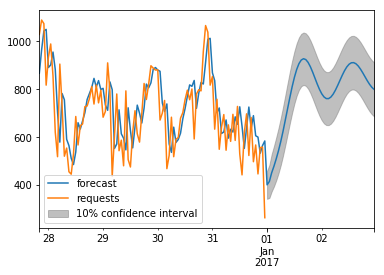

In [18]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings

# Select p and q
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    arma_params = arma_order_select_ic(series, fit_kw=dict(method='css'))

p = arma_params.bic_min_order[0]
q = arma_params.bic_min_order[1]

arima = ARIMA(series, order=(p,0,q))
arima_fit = arima.fit()

print(arima_fit.forecast(48)[0])
arima_fit.plot_predict(start=series.tail(100).index[0],
                       end=series.last_valid_index() + pd.Timedelta(hours=48),
                       alpha=0.90);